<a href="https://colab.research.google.com/github/JasmineD0401/SMA-LABS/blob/main/Topic_Modelling_(lab_05).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATASET**

Cleaned dataset - [clean_reviews.csv](https://drive.google.com/file/d/1mnI8lFqf2sobQn5TxFyhGkvL-WfbSw5i/view?usp=sharing)

Unprocessed dataset - [google.csv](https://drive.google.com/file/d/1P_cCP0paTAkpkAC4VB0nCKNS_-oqDlDb/view?usp=sharing)

In [ ]:
!pip install bert-extractive-summarizer
!pip install transformers
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=d84125d4dea9d9b6a29f72da55b6fed3e48fc2130529c1d211b3f36a20281e3a
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import BartForConditionalGeneration, BartTokenizer
from nrclex import NRCLex

In [ ]:
df=pd.read_csv('clean_reviews.csv')

In [ ]:
df.columns

Index(['info', 'Ratings', 'period', 'reviews', 'like/dislike', 'shared or not',
       'sentiment', 'sentiment_category'],
      dtype='object')

In [ ]:
df

,info,Ratings,period,reviews,like/dislike,shared or not,sentiment,sentiment_category
0,2 review,1.0,2024-01-04,last night went family dinner firstly unorgani...,like,share,0.088889,positive
1,1 review,5.0,2023-10-06,mayur hotel food ambience awesome party 50 per...,like,share,0.600000,positive
2,local guide 25 review 9 photo,3.0,2023-11-05,room clean interior need upgraded service food...,like,share,0.341667,positive
3,24 review 2 photo,5.0,2023-11-05,fresh tasty food veg non veg service quick man...,like,share,0.444444,positive
4,6 review,5.0,2023-10-06,overall great staff service location everythin...,like,share,0.395238,positive
...,...,...,...,...,...,...,...,...
1024,local guide 2 review 182 photo,4.0,NaN,no review,like,share,0.000000,neutral
1025,2 review 4 photo,5.0,NaN,no review,like,share,0.000000,neutral
1026,4 review 4 photo,5.0,NaN,no review,like,share,0.000000,neutral
1027,local guide 23 review 4 photo,2.0,2019-03-06,ok ok,like,share,0.500000,positive


# Topic Modelling


In [ ]:

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

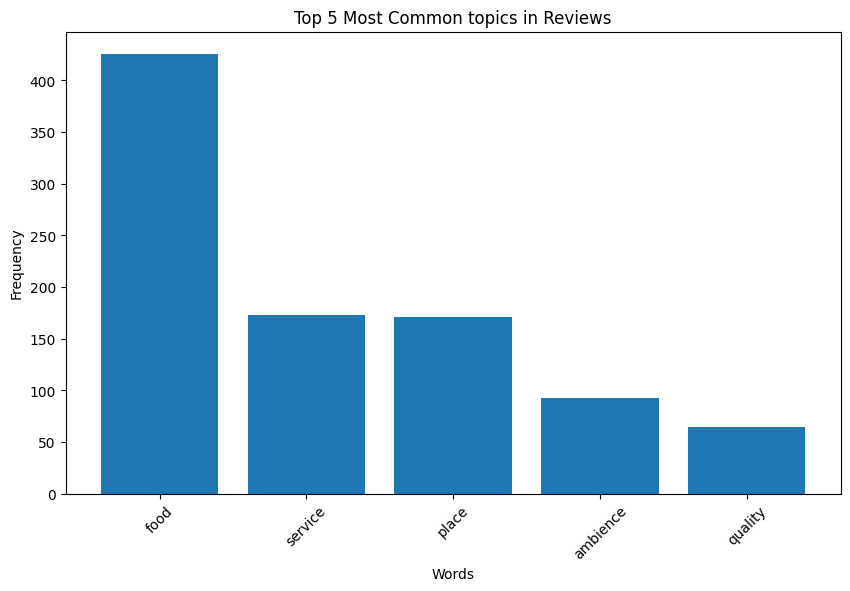

In [ ]:
# Extract the 'reviews' column from the DataFrame
reviews = df['reviews']

# Convert reviews to strings and combine them into a single string
text_data = ' '.join(reviews.astype(str))

# Tokenize the text
tokens = word_tokenize(text_data)

# Perform Part-of-Speech (POS) tagging
tagged_tokens = nltk.pos_tag(tokens)

# Define a list of stopwords and POS tags to exclude
stop_words = set(stopwords.words('english'))
excluded_pos_tags = ['CC', 'CD', 'DT', 'EX', 'IN', 'LS', 'MD', 'PRP', 'PRP$', 'TO', 'WDT', 'WP', 'WP$', 'WRB']

# Custom stopwords to exclude
custom_stopwords = ['good','nice','review','restaurant','family','hotel','veg','shiv','experience','sagar','time']  # Add your custom stopwords here

# Combine all stopwords
all_stopwords = stop_words.union(custom_stopwords)

# Filter out non-noun words and stopwords
filtered_tokens = [word for word, pos in tagged_tokens if pos.startswith('NN') and word.isalnum() and word not in all_stopwords]

# Count frequency of each word
word_freq = Counter(filtered_tokens)

# Plot the most common words
most_common_words = word_freq.most_common(5)  # Change 10 to desired number of top words
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Most Common topics in Reviews')
plt.xticks(rotation=45)
plt.show()

Wall of fame and wall of shame


In [ ]:
# Assuming your DataFrame is named 'df' and contains the necessary columns

# Define thresholds for positive and negative sentiment scores
positive_threshold = 0.5  # Example threshold for positive sentiment
negative_threshold = -0.5  # Example threshold for negative sentiment

# Initialize Wall of Fame and Wall of Shame lists
wall_of_fame = []
wall_of_shame = []

# Iterate through the reviews
for index, row in df.iterrows():
    if isinstance(row['reviews'], str) and 'food' in row['reviews'].lower():  # Check if the review is a string and mentions "food"
        # Perform sentiment analysis on the review text
        review_sentiment = TextBlob(row['reviews']).sentiment.polarity
        if review_sentiment >= positive_threshold:
            wall_of_fame.append(row['reviews'])
        elif review_sentiment <= negative_threshold:
            wall_of_shame.append(row['reviews'])

# Display the Wall of Fame
print("Top 10 Positive Reviews about Food (Wall of Fame):")
for review in wall_of_fame[:10]:
    print("-", review)

# Display the Wall of Shame
print("\nTop 10 Negative Reviews about Food (Wall of Shame):")
for review in wall_of_shame[:10]:
    print("-", review)

Top 10 Positive Reviews about Food (Wall of Fame):
- mayur hotel food ambience awesome party 50 person 9pm hall ambience good staff helpful like dish spinach inthai sauce much overall nice experience good hotel food service
- wonderful experience resort cum hotel good food choice available nice jacoobi adventurous journey
- room neat clean staff courteous helpful stayed week nice stay good hotel family stay also food nice hotel hotel mayur nice hotel stay food
- ambience good given royal look place make beautiful service good quick nice good amount staff food quality also good didnt found taste superb hotel rate 355 taste not bad also price lil bit higher compare hotel ulhasnagar
- recently visited hotel mayur sapphire banquet hall attending ring ceremony experience mind blowing taste food yummy tasty ambiance excellent staff helpful co operative
- good hotel around ulhasnagar good food good ambience ideal family function get together party marriage name facility complete package
- exc

Trend Analysis: Number of reviews over time


<ipython-input-11-631d950e071f>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'period'] = pd.to_datetime(df['period'])


<Figure size 1000x600 with 0 Axes>

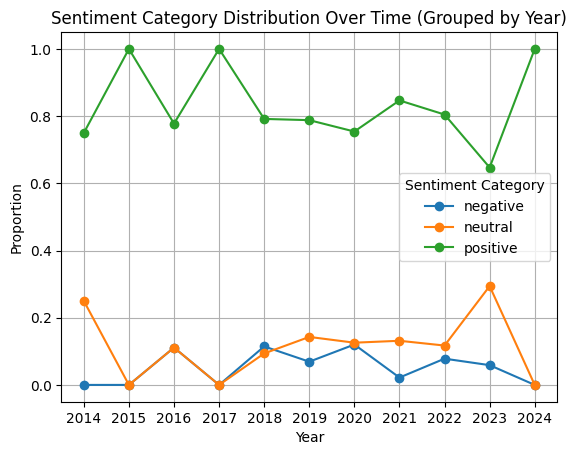

In [ ]:
# Convert 'period' column to datetime type using .loc
df.loc[:, 'period'] = pd.to_datetime(df['period'])

# Group by year and sentiment category, calculate normalized value counts, and unstack the result
yearly_counts = df.groupby(df['period'].dt.year)['sentiment_category'].value_counts(normalize=True).unstack().fillna(0)

# Visualization
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='line', marker='o')
plt.title('Sentiment Category Distribution Over Time (Grouped by Year)')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend(title='Sentiment Category')
plt.grid(True)
plt.xticks(yearly_counts.index)  # Set x-axis labels to years
plt.show()

<Figure size 1000x600 with 0 Axes>

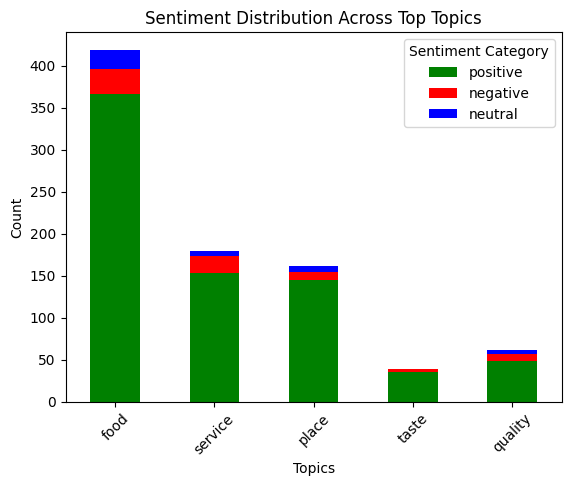

In [ ]:
# Filter out non-string values in the 'reviews' column
df = df[df['reviews'].apply(lambda x: isinstance(x, str))]

# Define the top 5 topics
top_topics = ['food', 'service', 'place', 'taste', 'quality']

# Initialize a dictionary to store sentiment categories for each topic
topic_sentiment_categories = {topic: {'positive': 0, 'negative': 0, 'neutral': 0} for topic in top_topics}

# Iterate through each review and count sentiment categories for the top topics
for review, sentiment_category in zip(df['reviews'], df['sentiment_category']):
    for topic in top_topics:
        # Check if the topic is mentioned in the review
        if topic in review.lower():
            # Increment count for the corresponding sentiment category
            topic_sentiment_categories[topic][sentiment_category] += 1

# Convert the dictionary to a DataFrame
topic_sentiment_categories_df = pd.DataFrame(topic_sentiment_categories).transpose()

# Define colors for positive, negative, and neutral sentiments
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

# Plotting the stacked histogram with different colors for each sentiment category
plt.figure(figsize=(10, 6))
topic_sentiment_categories_df.plot(kind='bar', stacked=True,
                                   color=[colors[sentiment]
                                          for sentiment in topic_sentiment_categories_df.columns])
plt.title('Sentiment Distribution Across Top Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Category')
plt.show()

In [ ]:


reviews=df['reviews']
# Concatenate all the reviews into a single text
combined_text = ' '.join(reviews)

# Initialize the BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Tokenize and encode the combined text
inputs = tokenizer([combined_text], max_length=1024, return_tensors='pt', truncation=True)

# Generate the summary
summary_ids = model.generate(inputs.input_ids, num_beams=4, max_length=150, early_stopping=True)

# Decode the summary
overall_summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)

# Print the overall summary
print("Overall Summary of Opinions:")
print(overall_summary)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Overall Summary of Opinions:
Last night went family dinner firstly unorganised staff super unhygienic environment importantly got hair food chicken gravy manager really normal unapologetic mayur hotel food ambience awesome party 50 person 9pm hall ambience good staff helpful like dish spinach inthai sauce much overall nice experience good hotel food service room clean interior need upgraded service food good.


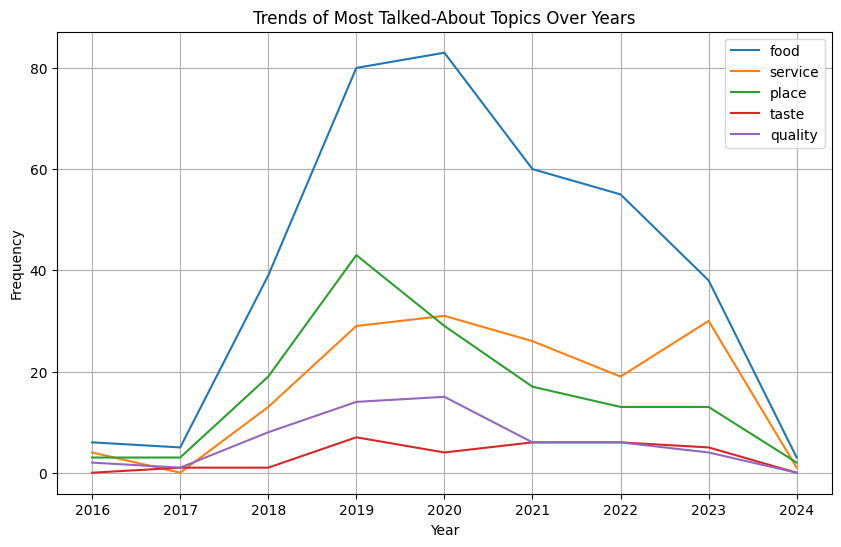

In [ ]:
# Filter the dataset to include only the reviews or documents mentioning the most talked-about topics
top_topics = ['food', 'service', 'place', 'taste', 'quality']  # Example list of most talked-about topics
filtered_df = df[df['reviews'].str.contains('|'.join(top_topics), case=False)]

# Convert the 'period' column to datetime format
# filtered_df['period'] = pd.to_datetime(filtered_df['period'])

# Perform temporal aggregation by year
yearly_counts = filtered_df.groupby(filtered_df['period'].dt.year)['reviews'].apply(lambda x: x.str.contains('|'.join(top_topics), case=False).sum())

# Visualize trends of most talked-about topics over time
plt.figure(figsize=(10, 6))
for topic in top_topics:
    plt.plot(yearly_counts.index, filtered_df['reviews'].str.contains(topic, case=False).groupby(filtered_df['period'].dt.year).sum(), label=topic)
plt.title('Trends of Most Talked-About Topics Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Initialize a dictionary to store emotion counts for each topic
topic_emotions = {topic: {} for topic in top_topics}

# Iterate through the reviews in the 'reviews' column
for review in df['reviews']:
    # Create NRCLex object for each review
    emotion = NRCLex(review)

    # Get the emotions associated with each topic in the review
    for topic in top_topics:
        if topic in review.lower():
            # Get the emotional categories mentioned in the review
            review_emotions = emotion.affect_list
            # Count the occurrences of each emotional category related to the topic
            for emotion_name in review_emotions:
                if emotion_name not in topic_emotions[topic]:
                    topic_emotions[topic][emotion_name] = 0
                topic_emotions[topic][emotion_name] += 1

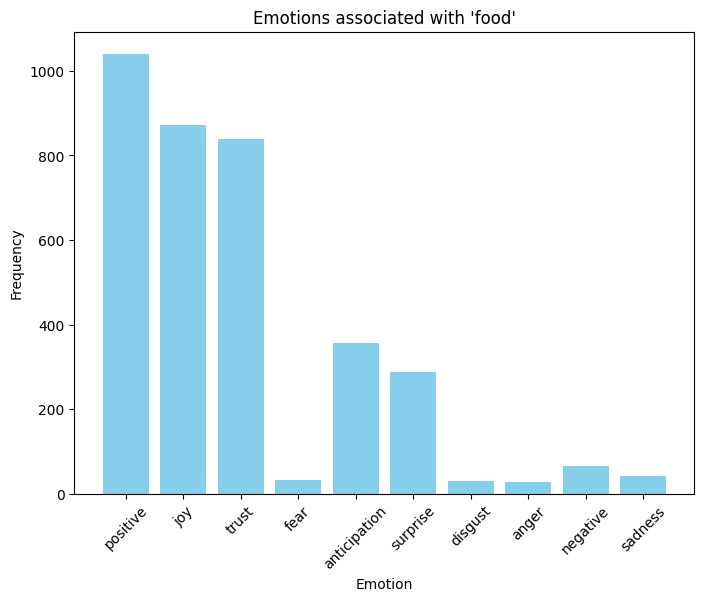

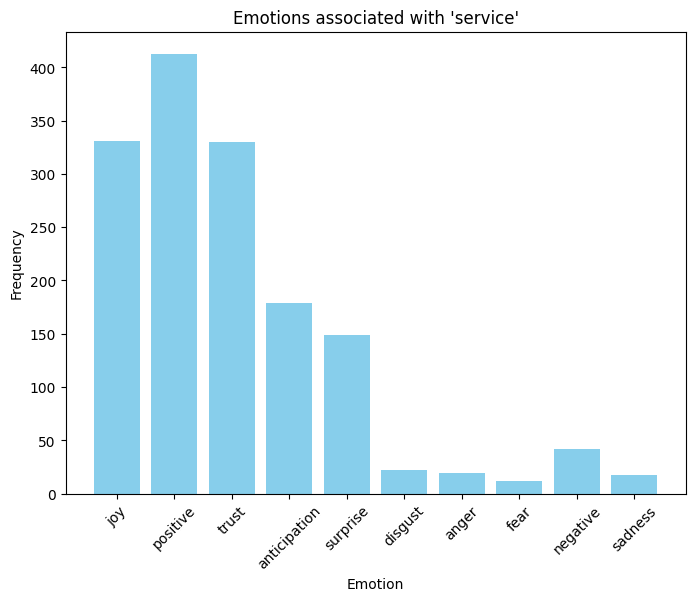

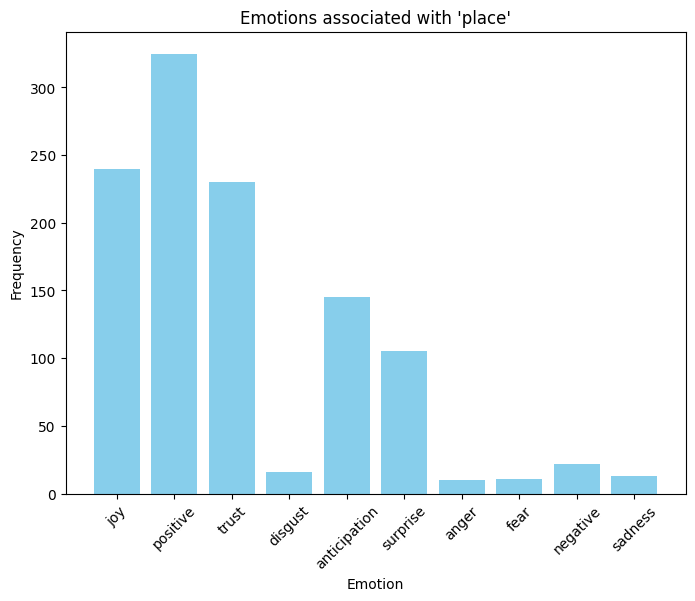

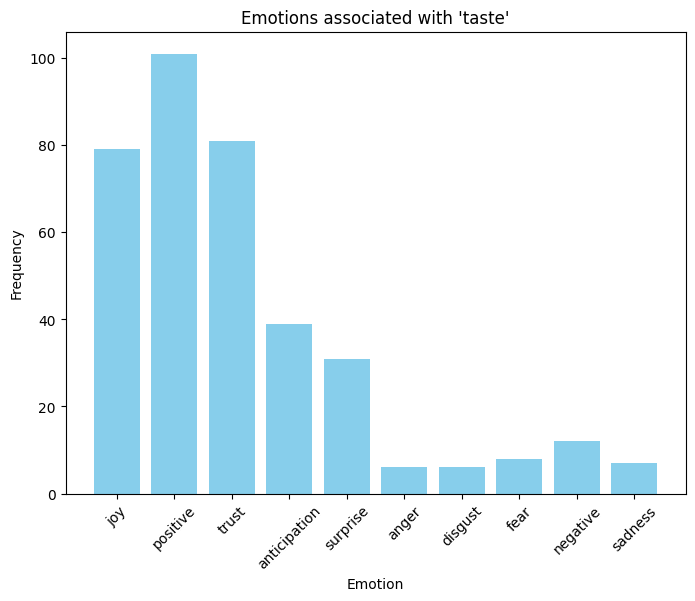

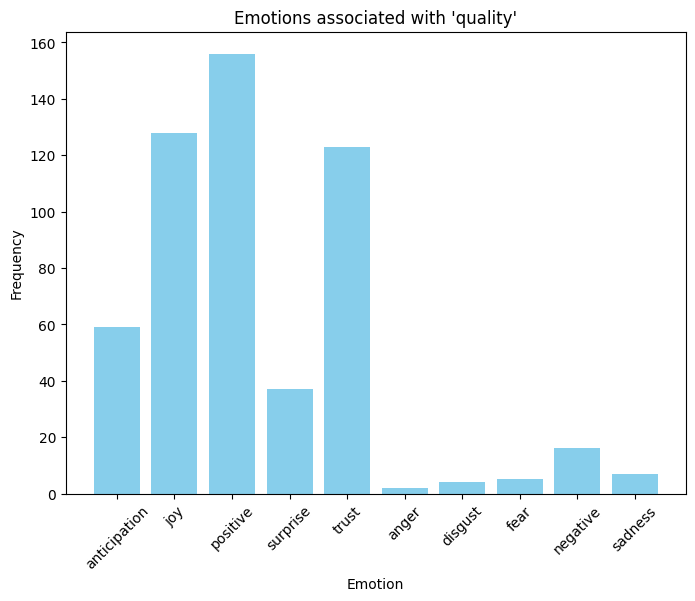

In [ ]:
for topic, emotions in topic_emotions.items():
    plt.figure(figsize=(8, 6))
    plt.bar(emotions.keys(), emotions.values(), color='skyblue')
    plt.title(f"Emotions associated with '{topic}'")
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()